In [594]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import sklearn.linear_model as linear

import scipy.stats as stats

import seaborn as sns

In [595]:
sns.set()

In [596]:
def cross_validation(
        data: pd.DataFrame,
        features: list,
        model_class = linear.SGDRegressor,
        target: str = 'price_doc',
        n_folds: int = 5
) -> (float, float):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=19)
    mse_list = []
    msle_list = []

    for train_index, val_index in kf.split(data):
        train = data.loc[train_index, : ]
        val = data.loc[val_index, : ]

        model = model_class()
        model.fit(train[features], train[target])

        prediction = model.predict(val[features])
        prediction = prediction.clip(0.0001, 100000000000)

        mse_list.append(mean_squared_error(prediction, val[target]))
        msle_list.append(mean_squared_log_error(prediction, val[target]))

    return np.mean(msle_list), np.std(msle_list)

In [597]:
leader_board = []

class Score:
    def __init__(
        self,
        cross_val_score : float,
        kaggle_private_score: float,
        model_name: str
    ):
        self.cross_val_score = cross_val_score
        self.kaggle_private_score = kaggle_private_score
        self.model_name = model_name

    def __str__(self):
        return str(self.kaggle_private_score) + " " + self.model_name + "\n"


### 1. Continuous features with filled omissions

In [598]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

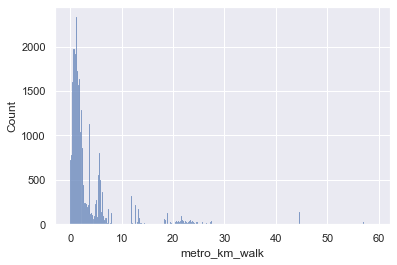

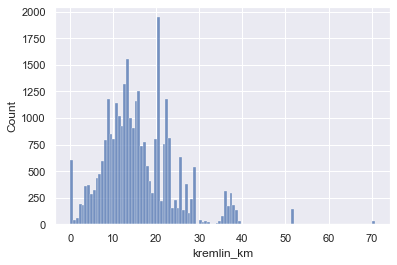

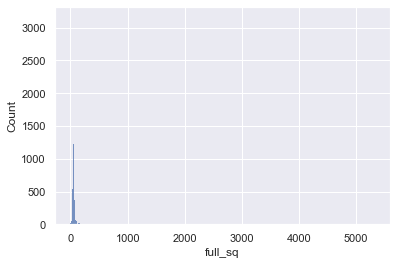

score: 97.39663055744316 
deviation: 88.50055552798425


In [599]:
for feature in features:
    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

    train[feature].clip(0.0001, 100000000000, inplace=True)
    test[feature].clip(0.0001, 100000000000, inplace=True)

    sns.histplot(train[feature])
    plt.show()

mean, std = cross_validation(train, features)
print("score:", mean, "\ndeviation:", std)

In [600]:
model = linear.SGDRegressor()
model.fit(train[features], train[target])

prediction = model.predict(test[features])
prediction = prediction.clip(0.0001, 100000000000)

In [601]:
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
sample_submission[target] = prediction
sample_submission.to_csv('../data/submissions/submission1.csv', index = False)

# ! kaggle competitions submit -c sberbank-russian-housing-market -f ../data/submissions/submission1.csv -m "1"

In [602]:
# result
leader_board.append(Score(
    cross_val_score=mean,
    kaggle_private_score=7.61077,
    model_name='SGDRegressor with numeric features'
))

### 2. Normalize features

In [603]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

Let's fill gaps with medians, clip negative values and make histograms.

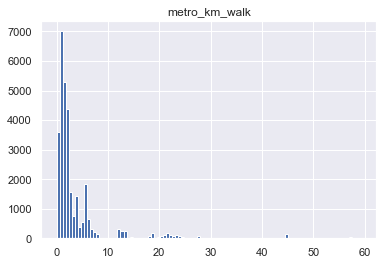

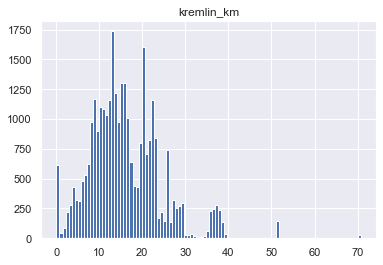

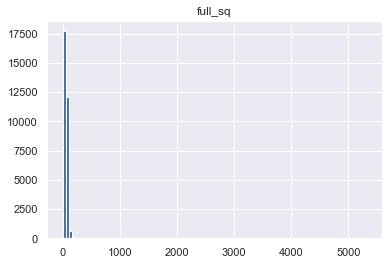

In [604]:
for feature in features:
    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

    train[feature].clip(0.0001, 100000000000, inplace=True)
    test[feature].clip(0.0001, 100000000000, inplace=True)

    plt.hist(train[feature], bins=100)
    plt.title(feature)
    plt.show()

Normalize data with box-cox function and fit it to standard distribution.

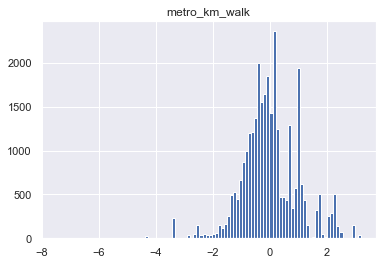

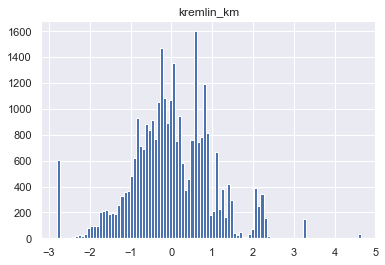

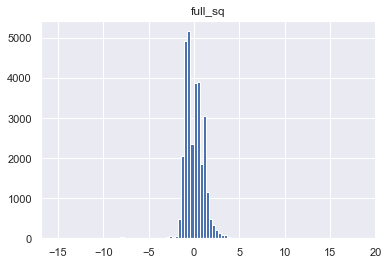

In [605]:
for feature in features:
    # normalize
    train[feature] = stats.boxcox(train[feature])[0]
    test[feature] = stats.boxcox(test[feature])[0]
    # normal -> standard (mean = 0, variance = 1)
    train[feature] = (train[feature]-train[feature].mean())/train[feature].std()
    test[feature] = (test[feature]-test[feature].mean())/test[feature].std()

    plt.hist(train[feature], bins=100)
    plt.title(feature)
    plt.show()

Now let's compute cross-validation score

In [606]:
mean, std = cross_validation(train, features)
print("score:", mean, "\ndeviation:", std)

score: 1.399137246988826 
deviation: 0.24071313534351776


Wow! Big improvement!

In [607]:
model = linear.SGDRegressor()
model.fit(train[features], train[target])

prediction = model.predict(test[features])
prediction = prediction.clip(0.0001, 100000000000)

In [608]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission[target] = prediction
submission.to_csv('../data/submissions/submission2.csv', index = False)

# ! kaggle competitions submit -c sberbank-russian-housing-market -f ../data/submissions/submission2.csv -m "2"

In [609]:
# result
leader_board.append(Score(
    cross_val_score=mean,
    kaggle_private_score=1.36423,
    model_name='SGDRegressor with normalized numeric features'
))

### 3. Categorical data and target encoding

Let's select several categorical features

In [610]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

train.select_dtypes(include=[object]).columns.values

array(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion',
       'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line',
       'big_road1_1line', 'railroad_1line', 'ecology'], dtype=object)

I like these ones:

In [611]:
features = [
    'product_type',
    'sub_area',
    'railroad_terminal_raion',
    'big_market_raion'
]

target = 'price_doc'

Not let's make **target encoding** and draw some plots

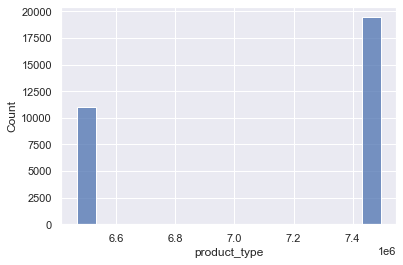

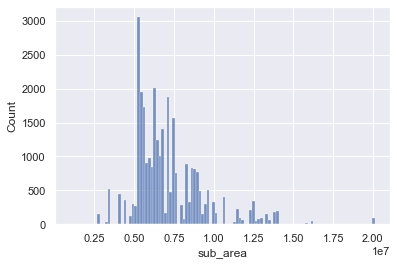

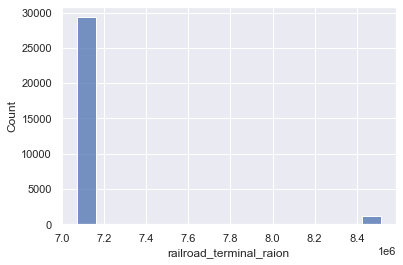

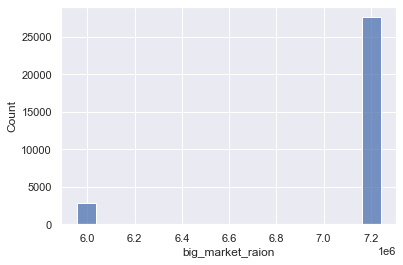

In [612]:
for feature in features:
    target_encoded = train.groupby([feature])[target].mean()
    train[feature].replace(target_encoded, inplace=True)
    test[feature].replace(target_encoded, inplace=True)

    train[feature].clip(0.0001, 100000000000, inplace=True)
    test[feature].clip(0.0001, 100000000000, inplace=True)

    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

    sns.histplot(train[feature])
    plt.show()

Normalize data that seems to need normalization: 'sub_area'

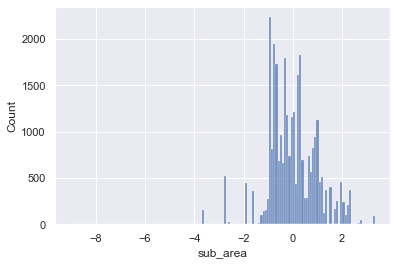

In [613]:
for feature in ['sub_area']:
    train[feature] = stats.boxcox(train[feature])[0]
    test[feature] = stats.boxcox(test[feature])[0]

    train[feature] = (train[feature]-train[feature].mean())/train[feature].std()
    test[feature] = (test[feature]-test[feature].mean())/test[feature].std()

    sns.histplot(train[feature])
    plt.show()

In [614]:
mean, std = cross_validation(train, features)
print("score:", mean, "\ndeviation:", std)

score: 184.20413201398748 
deviation: 73.08954118921511


Poor result.

In [615]:
mean, std = cross_validation(train, ['sub_area'])
print("score:", mean, "\ndeviation:", std)

score: 1.4402293964199377 
deviation: 0.17790103310281724


This one is much better!

**Hypothesis:** SGDRegressor is only useful with normally distributed data.

Let's try different model for this features.

In [616]:
mean, std = cross_validation(train, features, linear.ElasticNet)
print("score:", mean, "\ndeviation:", std)

score: 0.3412158267273385 
deviation: 0.02190067848484324


This is HUGE improvement!! Let's check result on kaggle

In [617]:
model = linear.ElasticNet()
model.fit(train[features], train[target])

prediction = model.predict(test[features])
prediction = prediction.clip(0.0001, 10000000000)

In [618]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission[target] = prediction
submission.to_csv('../data/submissions/submission3.csv', index = False)

# ! kaggle competitions submit -c sberbank-russian-housing-market -f ../data/submissions/submission3.csv -m "3"

In [619]:
# result
leader_board.append(Score(
    cross_val_score=mean,
    kaggle_private_score=0.46866,
    model_name='ElasticNet with categorical features'
))

### 4. Datetime features

In [620]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [621]:
datetime_features = [
    'month',
    'hour_datetime',
    'day_week',
    'day_month_datetime',
    'year'
]

def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    output= pd.DataFrame()
    output['timestamp'] = timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['hour_datetime'] = timestamp_series.dt.hour.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
#     _min = timestamp_series.iloc[0].astype(int)/1_000_000_000_000
#     output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000
    return output

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

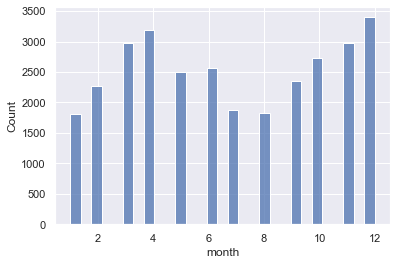

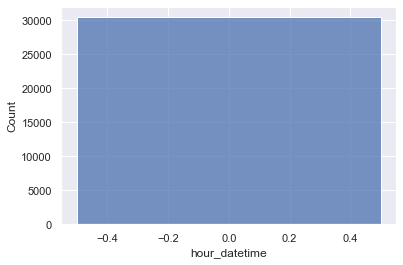

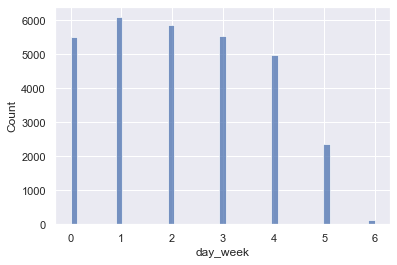

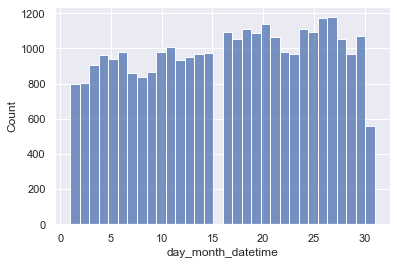

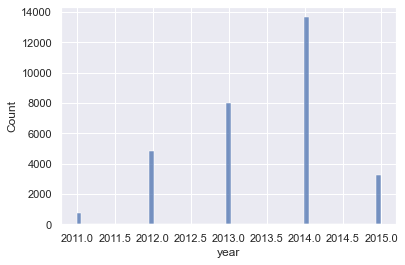

In [622]:
for feature in datetime_features:
    sns.histplot(train[feature])
    plt.show()


In [623]:
# Zero NaN's --> no need to use .fillna()
print("NaN values in datetime features:", train['timestamp'].isna().sum()[0])


NaN values in datetime features: 0


In [624]:
for feature in datetime_features:
    print(feature, set(train[feature].values))

month {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
hour_datetime {0}
day_week {0, 1, 2, 3, 4, 5, 6}
day_month_datetime {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
year {2011, 2012, 2013, 2014, 2015}


In [625]:
# 'hour_datetime' is constant, we don't need it
datetime_features.remove('hour_datetime')

# increase day_week by 1 to make values positive
train['day_week'] += 1
test['day_week'] += 1

In [626]:
mean, std = cross_validation(train, datetime_features, linear.ElasticNet)
print("score:", mean, "\ndeviation:", std)

score: 0.38723265742442836 
deviation: 0.011153595739565848


In [627]:
model = linear.ElasticNet()
model.fit(train[datetime_features], train[target])

prediction = model.predict(test[datetime_features])
prediction = prediction.clip(0.0001, 100000000000)

In [628]:
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
sample_submission[target] = prediction
sample_submission.to_csv('../data/submissions/submission4.csv', index = False)

# ! kaggle competitions submit -c sberbank-russian-housing-market -f ../data/submissions/submission4.csv -m "4"

In [629]:
leader_board.append(Score(
    cross_val_score=mean,
    kaggle_private_score=0.55672,
    model_name='ElasticNet with datetime features'
))

### 5. Combined data

In [630]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [631]:
num_features = [
    'full_sq',
    'life_sq',
    'full_sq',
    'floor',
    'max_floor',
    'build_year',
    'num_room',
    'kitch_sq'
]
cat_features = [
    'product_type',
    'sub_area',
    'railroad_terminal_raion',
    'big_market_raion'
]
datetime_features = [
    'month',
    'day_week',
    'day_month_datetime',
    'year'
]
features = num_features + cat_features + datetime_features
target = 'price_doc'

In [632]:
for feature in cat_features:
    target_encoded = train.groupby([feature])[target].mean()
    train[feature].replace(target_encoded, inplace=True)
    test[feature].replace(target_encoded, inplace=True)

    train[feature].clip(0.0001, 100000000000, inplace=True)
    test[feature].clip(0.0001, 100000000000, inplace=True)

    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

In [633]:
for feature in num_features + ['sub_area']:
    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

    train[feature].clip(0.0001, 100000000000, inplace=True)
    test[feature].clip(0.0001, 100000000000, inplace=True)

    train[feature] = stats.boxcox(train[feature])[0]
    test[feature] = stats.boxcox(test[feature])[0]

    train[feature] = (train[feature]-train[feature].mean())/train[feature].std()
    test[feature] = (test[feature]-test[feature].mean())/test[feature].std()

In [634]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    output= pd.DataFrame()
    output['timestamp'] = timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    return output

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

train['day_week'] += 1
test['day_week'] += 1


In [635]:
mean, std = cross_validation(train, features, linear.ElasticNet)
print("score:", mean, "\ndeviation:", std)

score: 0.3869903419658858 
deviation: 0.07440100122496092


Improvement is not that big, though.

In [636]:
model = linear.ElasticNet()
model.fit(train[features], train[target])

prediction = model.predict(test[features])
prediction = prediction.clip(0.0001, 100000000000)

In [637]:
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
sample_submission[target] = prediction
sample_submission.to_csv('../data/submissions/submission5.csv', index = False)

# ! kaggle competitions submit -c sberbank-russian-housing-market -f ../data/submissions/submission5.csv -m "5"

In [638]:
leader_board.append(Score(
    cross_val_score=mean,
    kaggle_private_score=0.40467,
    model_name='ElasticNet with datetime features'
))

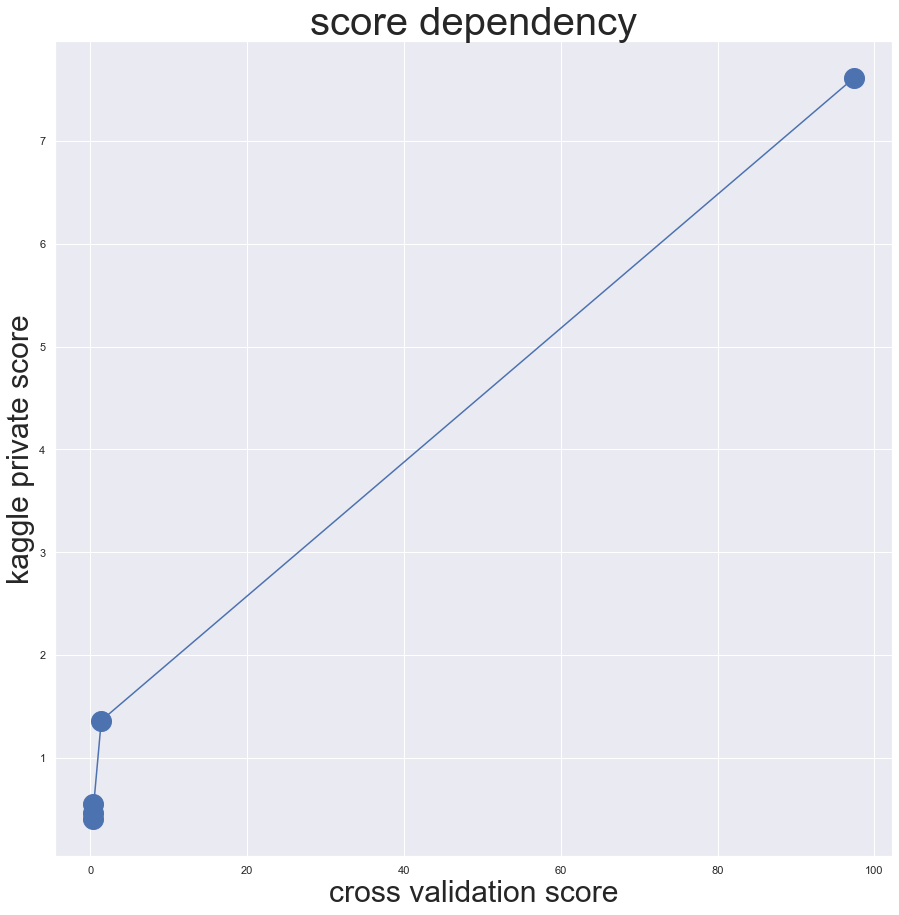

In [669]:
x = [score.cross_val_score for score in leader_board]
y = [score.kaggle_private_score for score in leader_board]
plt.figure(figsize=(15, 15))
plt.title('score dependency', size=40)
plt.xlabel('cross validation score', size=30)
plt.ylabel('kaggle private score', size=30)
plt.plot(x, y, marker=".", markersize=40)

### Выводы
(Почему-то теперь пишу по-русски)

#### По соревнованию и домашке
- Лучше всех справилась модель sklearn.linear_models.ElasticNet, обученная на полном наборе
подготовленных данных: числовых, категориальных и datetime
- SGDRegressor работает так себе
- Объединить данные помогло, но не очень сильно, хватило бы и меньшего набора фичей
- Кросс-валидация очень неплохо предсказывает итоговый скор, зависимость на графике это доказывает.

#### На будущее
- Данные, если их много и они имеют какое-то распределение, лучше отнормировать
- SGDRegressor умеет работать только для нормального распределения
- Target encoding - лучший способ закодировать категориальные признаки
- Timestamp лучше разбить на datetime-фичи (час, месяц, год и т.д.), а дальше работать как с категориальными признаками
- Pandas - непредсказуемое чудовище
- Линейных (да и вообще) моделей - куча, нужно пробовать их все и
играться с параметрами и выбором модели в зависимости от задачи.
В следующих домашках нужно будет уделить этому побольше времени.
